# Before we begin...

## Why are we interested in thinking about images as signals?

The first and most obvious answer to this question is, well, because they are. But the real question here is, *how can signal processing concepts expand my image analysis toolbox?*

Lets start by showing an example adapted from [Elegant Scipy](https://github.com/elegant-scipy), written by Juan Nunez-Iglesias (@jni), Harriet Dashnow (@hdashnow), and Stéfan van der Walt (@stefanv), and published by O'Reilly Media.

In [1]:
from skimage import io
import matplotlib.pyplot as plt
import numpy as np
from scipy import fftpack

image = io.imread('../data/moonlanding.png')
M, N = image.shape

F = fftpack.fftn(image)
F_magnitude = np.abs(F)
F_magnitude = fftpack.fftshift(F_magnitude)
K = 40
F_magnitude[M // 2 - K: M // 2 + K, N // 2 - K: N // 2 + K] = 0
peaks = F_magnitude < np.percentile(F_magnitude, 98)
peaks = fftpack.ifftshift(peaks)
F_dim = F.copy()
F_dim = F_dim * peaks.astype(int)
image_filtered = np.real(fftpack.ifft2(F_dim))

f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))
ax[0].imshow(image, cmap='gray')
ax[0].set_title('Original image')
ax[1].imshow(image_filtered, cmap='gray')
ax[1].set_title('Filtered image');

By thinking of the image on the left as a signal, we can easily filter out components that are undesirable and recover the parts that we are interested in to produce the image on the right.

Scientists and engineers have had to deal with noisy or distorted signals for a long time, so we know a lot about how to deal with noise and distortion. With just a little bit of signal processing knowledge, you will be able to tackle problems such as the noisy `moonlanding.png` image shown above. By the end of this series, you will understand what is going on with this code example!

# Part 1: The Sampling Theorem and its Implications


## What is a signal?

A signal can be thought of as any measurement that varies over some dimension. Signals can be continuous (analog) or discrete (digital). They may or may not contain any obvious information, but it is their ability to carry meaningful information that interests us.

Lets take a look at a simple signal, a sine wave:

In [2]:
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('seaborn-colorblind')
font = {'size': 18}

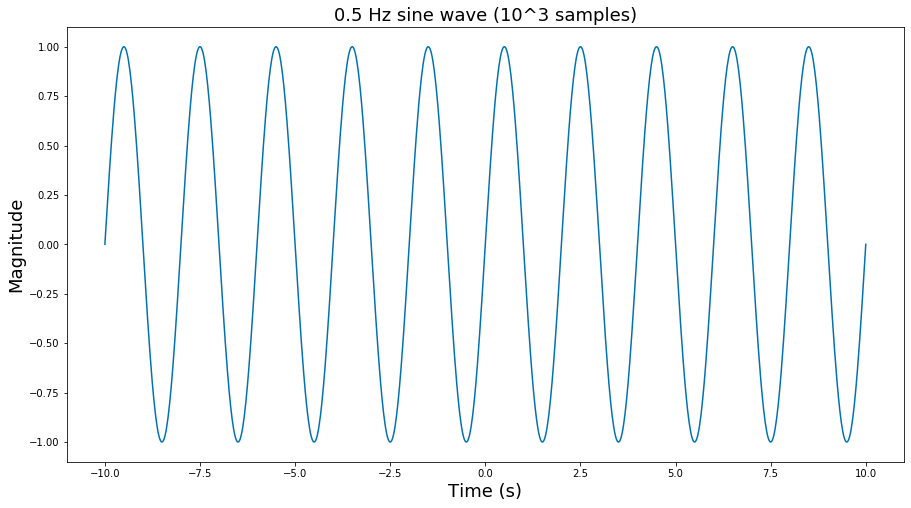

In [3]:
f = 1/2
n_samples = 1000

x = np.linspace(-10, 10, n_samples)
y = np.sin(x * f * (2 * np.pi))

# Plot
plt.figure(figsize=(15,8))
plt.plot(x,y)
plt.title('0.5 Hz sine wave (10^3 samples)', fontdict=font)
plt.xlabel('Time (s)', fontdict=font)
plt.ylabel('Magnitude', fontdict=font);

Here we have created a sine wave that completes one cycle every 2 seconds, so it has a frequency of $ \frac{1}{2} $ Hertz (0.5 Hz). `np.linspace` was used to create the x coordinates (1000 values, spaced evenly from -10 to 10 seconds, inclusive). The y coordinates are thus based on the $sin$ function. The plot looks smooth, mainly because we have many samples used to draw the curve — it is in fact a digital signal.


Lets take a look at what happens if we reduce the number of samples in our sine wave:

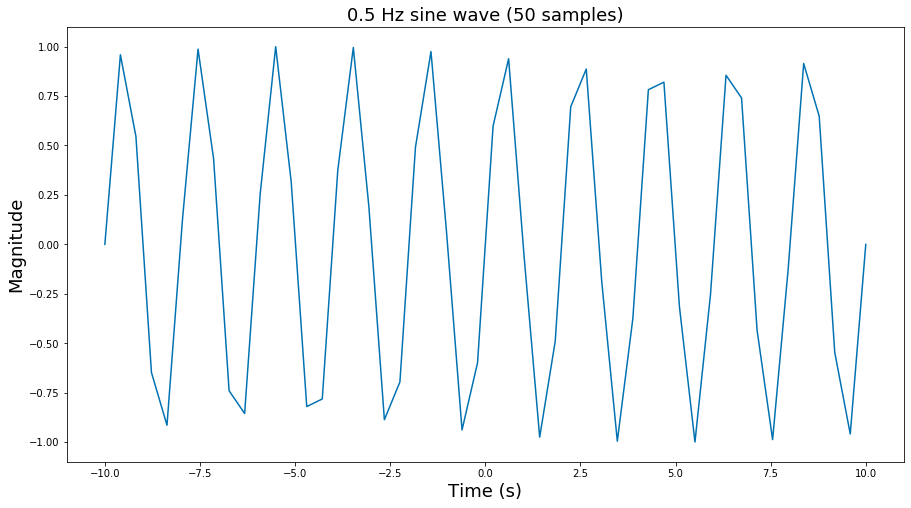

In [4]:
f = 1/2
n_samples = 50

x = np.linspace(-10, 10, n_samples)
y = np.sin(x * f * (2 * np.pi))

# Plot
plt.figure(figsize=(15,8))
plt.plot(x,y)
plt.title('0.5 Hz sine wave (50 samples)', fontdict=font)
plt.xlabel('Time (s)', fontdict=font)
plt.ylabel('Magnitude', fontdict=font);

This looks a bit jagged, but it is still clear that this is a wave-like signal with a frequency of 0.5 Hz. We will revisit the sampling rate, but for now the important thing to understand that this is a signal that carries some information. In this case, the information is the frequency of a wave (0.5 Hz in this case) and its phase (i.e. the position of the waveform with respect to the origin).

Not everything that looks like a signal necessarily carries information:

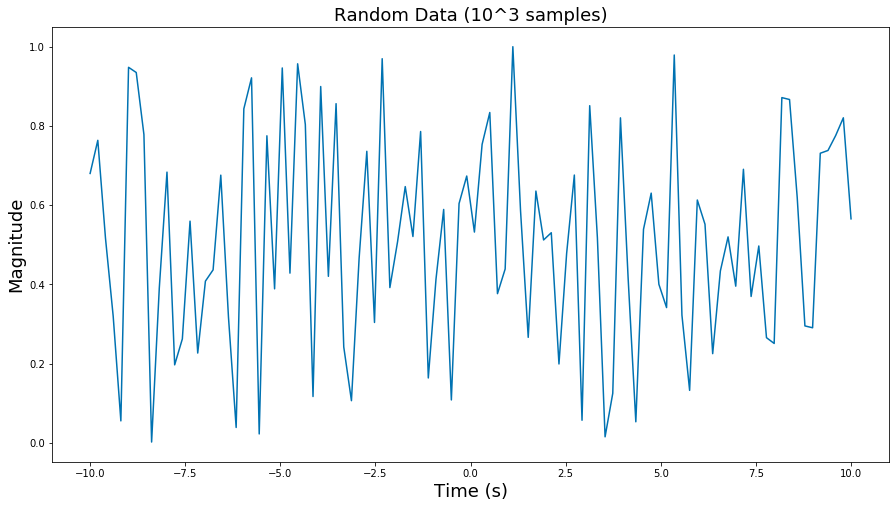

In [5]:
from numpy.random import random

n_samples = 100
x = np.linspace(-10, 10, n_samples)
y = random(n_samples)

# Plot
plt.figure(figsize=(15,8))
plt.plot(x, y)
plt.title('Random Data (10^3 samples)', fontdict=font)
plt.xlabel('Time (s)', fontdict=font)
plt.ylabel('Magnitude', fontdict=font);

Since this example contains random data, some might say that this is not a true signal, as it is not carrying information. Actually, there is some information here about the structure of the "noise" (e.g., values appear to have upper and lower bounds, follow a uniform distribution, etc.). Regardless, we could use signal processing techniques to inspect these data.

Importantly, real-world measurements tend to contain "real" signal components and "noise" components:

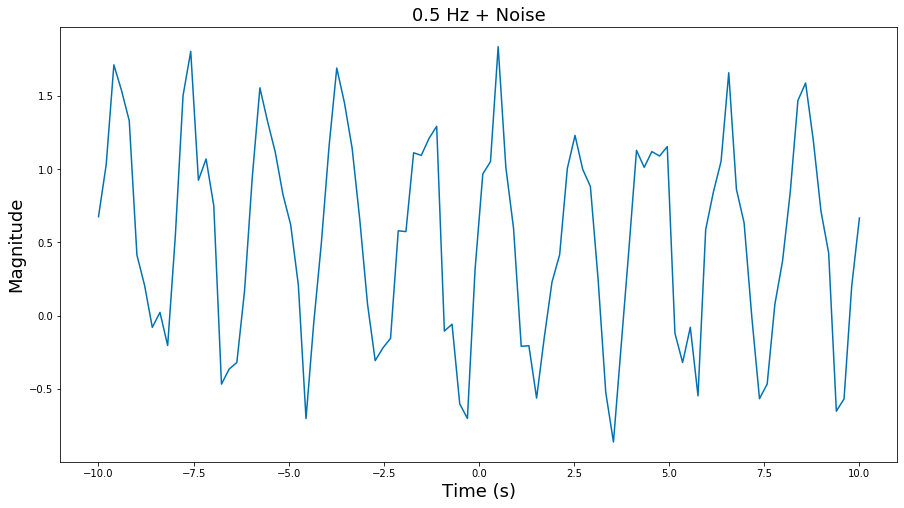

In [6]:
f = 1/2
n_samples = 100

x = np.linspace(-10, 10, n_samples)
y = np.sin(x * f * (2 * np.pi))
noise = random(n_samples) # make noise
y = y + noise # add noise

# Plot
plt.figure(figsize=(15,8))
plt.plot(x, y)
plt.title('0.5 Hz + Noise', fontdict=font)
plt.xlabel('Time (s)', fontdict=font)
plt.ylabel('Magnitude', fontdict=font);

Since the noise level is not terribly high compared to the "real" signal, it is still pretty easy to see the information (0.5 Hz) carried by this measurement.

When noise levels are higher, this becomes a much more difficult task:

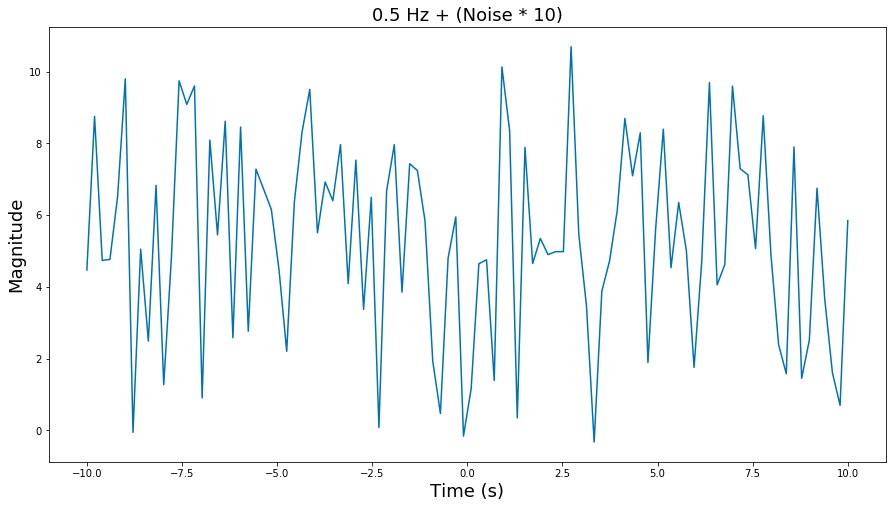

In [7]:
f = 1/2
n_samples = 100
noise_level = 10

x = np.linspace(-10, 10, n_samples)
y = np.sin(x * f * (2 * np.pi))
noise = random(n_samples) * noise_level
y = y + noise

plt.figure(figsize=(15,8))
plt.plot(x, y)
plt.title('0.5 Hz + (Noise * 10)', fontdict=font)
plt.xlabel('Time (s)', fontdict=font)
plt.ylabel('Magnitude', fontdict=font);

Most signals we want to analyze are much more complex than simple sine waves:

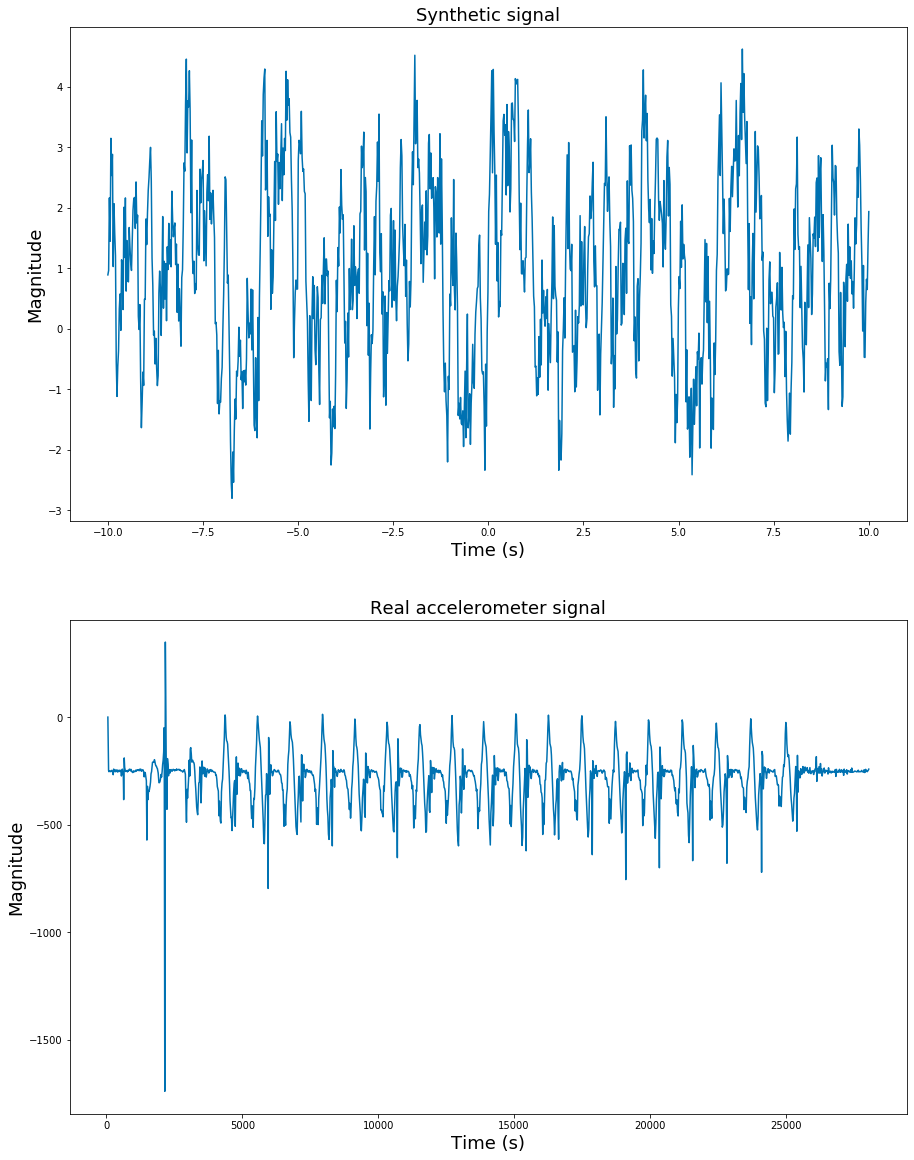

In [8]:
import pandas as pd

# synthetic "real" signal
f = [1/2, 1/3, 2, 3]
n_samples = 1000
noise_level = 2
x = np.linspace(-10, 10, n_samples)
y = [np.sin(x * freq * (2 * np.pi)) for freq in f] # create signal for each frequency
y = np.sum(y, axis=0) # sum up all frequencies
noise = random(n_samples) * noise_level
y = y + noise

# real signal from accelerometer
walk = pd.read_csv('../data/walk1.csv', header = None)
walk.columns = ['x', 'y', 'z', 't']


# plot
fig, ax = plt.subplots(2, figsize=(15,20))
ax[0].set_title('Synthetic signal', fontdict=font)
ax[0].plot(x, y)
ax[0].set_xlabel('Time (s)', fontdict=font)
ax[0].set_ylabel('Magnitude', fontdict=font)

ax[1].set_title('Real accelerometer signal', fontdict=font)
ax[1].plot(walk.t, walk.x)
ax[1].set_xlabel('Time (s)', fontdict=font)
ax[1].set_ylabel('Magnitude', fontdict=font);



Looking at these plots, you can start to appreciate how it can be difficult to separate signal from noise. And even if you know what the real signal is, how do you start to make sense of it? These are the primary concerns of signal processing.

## Aliasing

In the first example above, we saw how sampling rate can affect the appearance of a signal. At a ~50 Hz sampling rate, our 0.5 Hz sine wave looked smooth. At a ~2.5 Hz sampling rate, the signal looked jagged, but we were still able to see something that looked like a 0.5 Hz sine wave.

Lets take a look at what happens when we sample at the same rate as the signal:

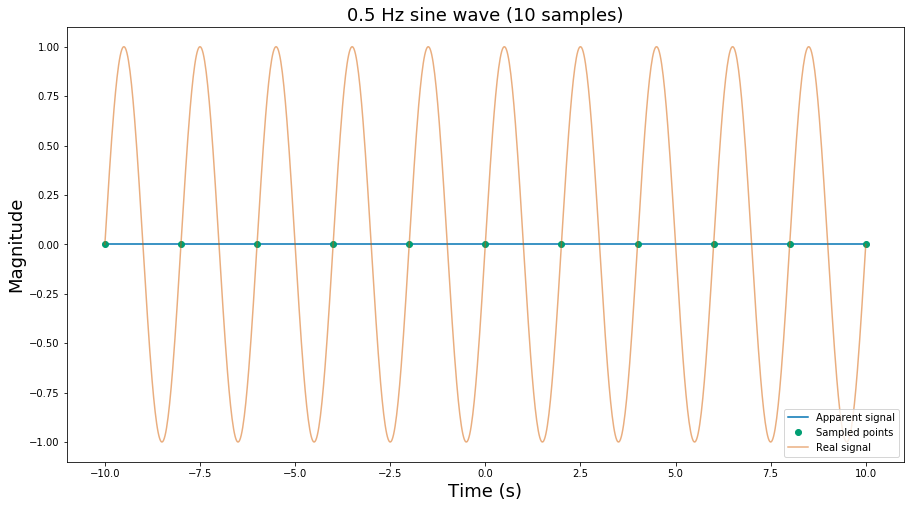

In [9]:
f = 1/2
n_samples = 11 # 0.5 Hz sampling plus endpoint

x = np.linspace(-10, 10, n_samples)
y = np.sin(x * f * (2 * np.pi))

x_smooth = np.linspace(-10, 10, 1000)
y_smooth = np.sin(x_smooth * f * (2 * np.pi))

# Plot
plt.figure(figsize=(15,8))
plt.plot(x, y)
plt.plot(x, y, 'o')
plt.plot(x_smooth, y_smooth, alpha=0.5)
plt.title('0.5 Hz sine wave (10 samples)', fontdict=font)
plt.legend(('Apparent signal', 'Sampled points', 'Real signal'), loc=4)
plt.xlabel('Time (s)', fontdict=font)
plt.ylabel('Magnitude', fontdict=font);

This doesn't look like a sine wave at all! In fact, we have apparently lost our signal. Lets take a look at some sampling rates near the frequency of the sine wave:

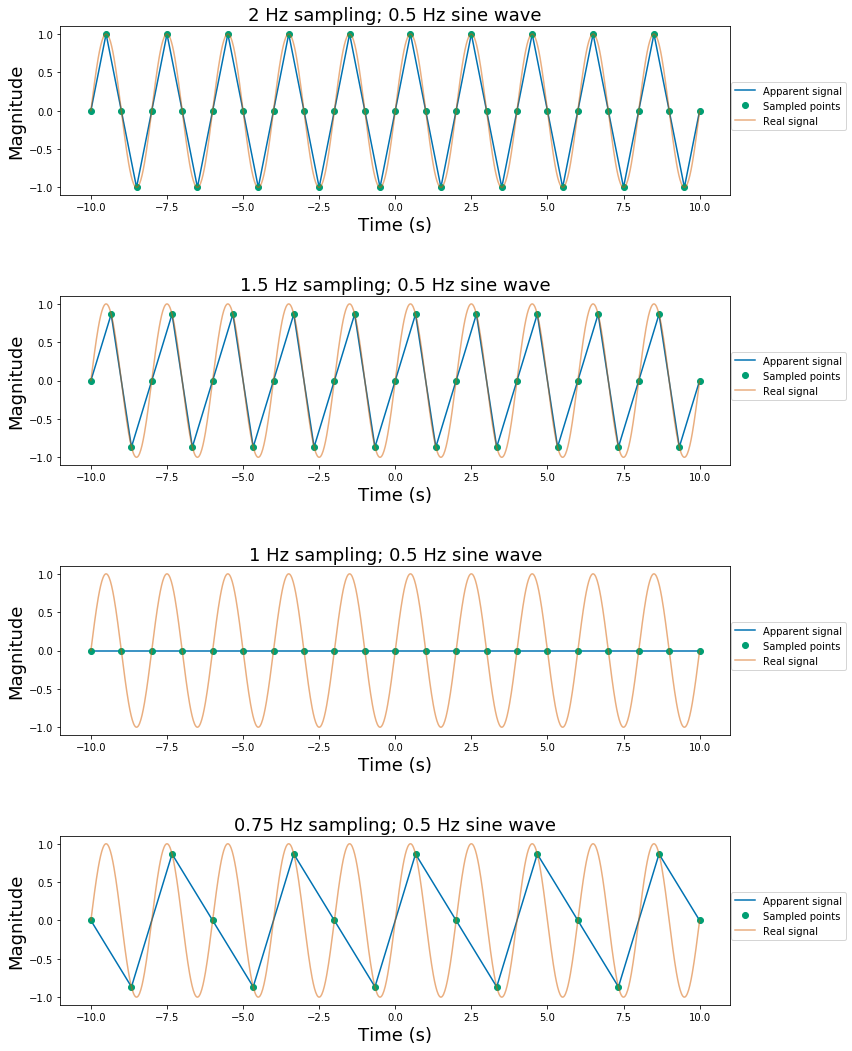

In [10]:
f = 1/2
n_samples = [41, 31, 21, 16]
rates = ['2 Hz', '1.5 Hz', '1 Hz', '0.75 Hz']

x = [np.linspace(-10, 10, n) for n in n_samples]
y = [np.sin(sig * f * (2 * np.pi)) for sig in x]
x_smooth = np.linspace(-10, 10, 1000)
y_smooth = np.sin(x_smooth * f * (2 * np.pi))


# Plot
fig, ax = plt.subplots(len(n_samples), figsize=(12, 18))
fig.subplots_adjust(hspace=0.6)
for i in range(len(n_samples)):
    ax[i].set_title(rates[i] + " sampling; 0.5 Hz sine wave", fontdict=font)
    ax[i].set_xlabel('Time (s)', fontdict=font)
    ax[i].set_ylabel('Magnitude', fontdict=font)
    ax[i].plot(x[i], y[i])
    ax[i].plot(x[i], y[i], 'o')
    ax[i].plot(x_smooth, y_smooth, alpha=0.5)
    ax[i].legend(('Apparent signal', 'Sampled points', 'Real signal'),
                 bbox_to_anchor=(1.18, 0.7))

You can see that at 2 Hz and 1.5 Hz sampling, we get something that looks fairly accurate with respect to the frequency of the underlying sine wave. At 0.75 Hz sampling, we get a very inaccurate picture!

1 Hz sampling is an interesting case. Here, we lose our signal altogether, but watch what happens when we shift the sampling a bit along the time axis:

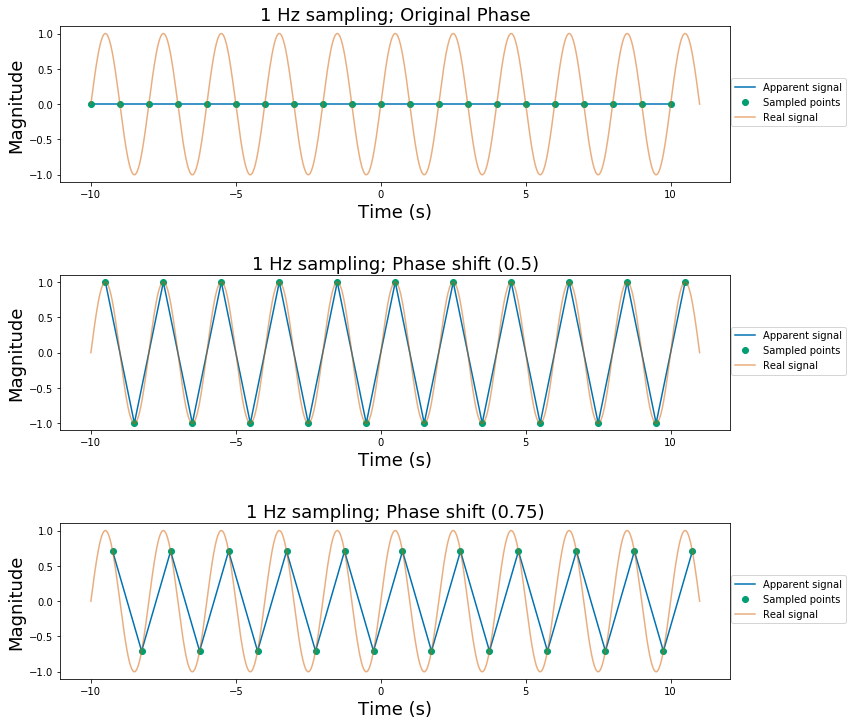

In [23]:
f = 1/2
n_samples = 21

x = np.linspace(-10, 10, n_samples)
y = np.sin(x*f*(2*np.pi))

x_shift1 = x + 0.5
y_shift1 = np.sin(x_shift1 * f * (2 * np.pi))

x_shift2 = x + 0.75
y_shift2 = np.sin(x_shift2 * f * (2 * np.pi))

x_smooth = np.linspace(-10, 11, 1000)
y_smooth = np.sin(x_smooth * f * (2 * np.pi))

# Plot
fig, ax = plt.subplots(3, figsize=(12,12))
fig.subplots_adjust(hspace=0.6)

# Top plot
ax[0].set_title('1 Hz sampling; Original Phase', fontdict=font)
ax[0].set_xlabel('Time (s)', fontdict=font)
ax[0].set_ylabel('Magnitude', fontdict=font)
ax[0].plot(x, y)
ax[0].plot(x, y, 'o')
ax[0].plot(x_smooth, y_smooth, alpha=0.5)
ax[0].legend(('Apparent signal', 'Sampled points', 'Real signal'),
             bbox_to_anchor=(1.18, 0.7))

#Middle plot
ax[1].set_title('1 Hz sampling; Phase shift (0.5)', fontdict=font)
ax[1].set_xlabel('Time (s)', fontdict=font)
ax[1].set_ylabel('Magnitude', fontdict=font)
ax[1].plot(x_shift1, y_shift1)
ax[1].plot(x_shift1, y_shift1, 'o')
ax[1].plot(x_smooth, y_smooth, alpha=0.5)
ax[1].legend(('Apparent signal', 'Sampled points', 'Real signal'),
             bbox_to_anchor=(1.18, 0.7))

# Bottom plot
ax[2].set_title('1 Hz sampling; Phase shift (0.75)', fontdict=font)
ax[2].set_xlabel('Time (s)', fontdict=font)
ax[2].set_ylabel('Magnitude', fontdict=font)
ax[2].plot(x_shift2, y_shift2)
ax[2].plot(x_shift2, y_shift2, 'o')
ax[2].plot(x_smooth, y_smooth, alpha=0.5)
ax[2].legend(('Apparent signal', 'Sampled points', 'Real signal'),
             bbox_to_anchor=(1.18, 0.7));

Here we can see that 1 Hz sampling is sufficient to detect our 0.5 Hz signal, but only if we can sample across different phases. Note that this is very much not the case for lower sampling rates:

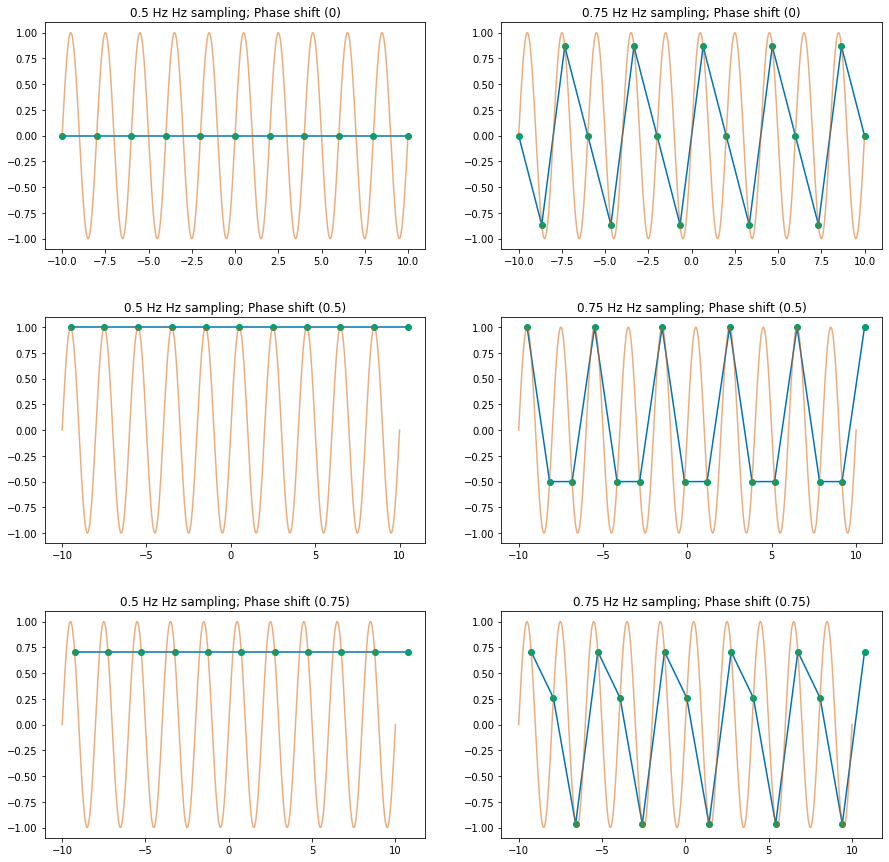

In [12]:
f = 1/2
n_samples = [11, 16]
rates = ['0.5 Hz', '0.75 Hz']
shifts = [0, 0.5, 0.75]
x_smooth = np.linspace(-10, 10, 1000)
y_smooth = np.sin(x_smooth * f * (2 * np.pi))

rows = len(shifts)
cols = len(rates)

# Plot
fig, ax = plt.subplots(nrows=rows,
                       ncols=cols,
                       figsize=(15, 15))
fig.subplots_adjust(hspace=.3)

for col in range(cols):
    for row in range(rows):
        x = np.linspace(-10, 10, n_samples[col]) + shifts[row]
        y = np.sin(x * f * (2 * np.pi))
        ax[row, col].set_title(f"{rates[col]} Hz sampling; "
                               f"Phase shift ({shifts[row]})")
        ax[row, col].plot(x, y)
        ax[row, col].plot(x, y, 'o')
        ax[row, col].plot(x_smooth, y_smooth, alpha=0.5)

So no matter what phase you sample at, if your sampling frequency is equal to your sine wave frequency, you won't be able to detect the sine wave because the signal looks constant.

And when your sampling frequency is only 1.5x your "true" sine wave frequency, you end up with confusing results. In fact, multiple different sine waves would "fit" the 0.75 Hz sampling case:

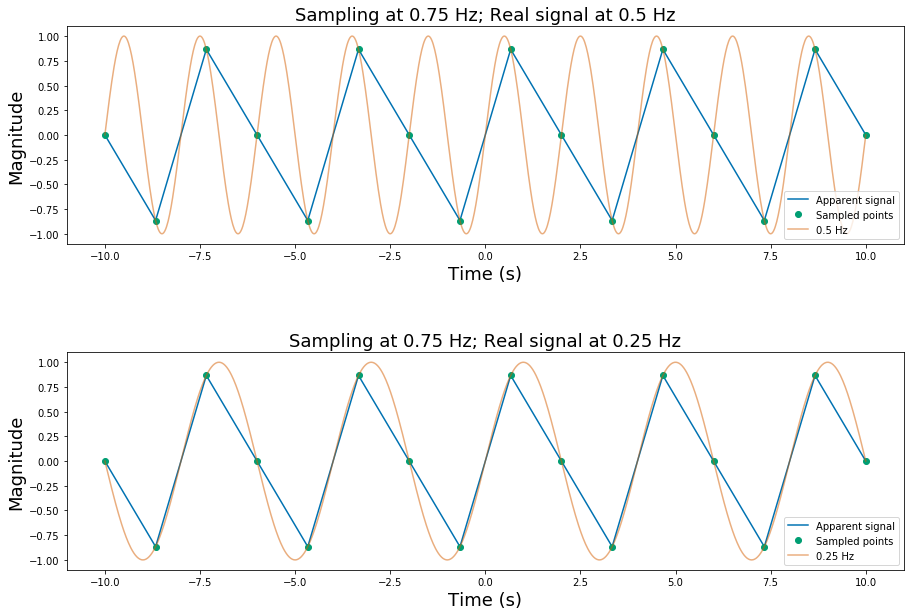

In [28]:
freqs = [1/2, 1/4]
n_samples = 16 #0.75 Hz

x = np.linspace(-10, 10, n_samples)
y = np.sin(x * freqs[0] * (2 * np.pi))
x_smooth = np.linspace(-10, 10, 1000)

# Plot
fig, ax = plt.subplots(2, figsize=(15, 10))
fig.subplots_adjust(hspace=.5)

for i,f in enumerate(freqs):
    y_smooth = np.sin(x_smooth * f * (2 * np.pi))
    ax[i].set_title(f'Sampling at 0.75 Hz; Real signal at {f} Hz',
                   fontdict=font)
    ax[i].set_xlabel('Time (s)', fontdict=font)
    ax[i].set_ylabel('Magnitude', fontdict=font)
    ax[i].plot(x, y)
    ax[i].plot(x, y, 'o')
    ax[i].plot(x_smooth, y_smooth, alpha=0.5)
    ax[i].legend(("Apparent signal","Sampled points",f"{f} Hz"), loc=4)

These simple examples have illustrated an import concept in signal processing called the **sampling theorem** (often called the **Nyquist-Shannon sampling theorem**). From Shannon's original paper (Proceedings of the Institute of Radio Engineers. 37 (1): 10–21):

> If a function $f ( t )$ contains no frequencies higher than W \[hertz\], it is completely determined by giving its ordinates at a series of points spaced $1 / ( 2 W )$ seconds apart.

The "contains no frequencies" and "completely determined" parts of the quote might not make a lot of sense to you now, but we will discuss what that means later. With regard to our simple case here, we can simplify - we can't accurately depict a sine wave unless we sample at least twice its frequency.

Moreoever, the phase relationship between the signal and our sampling matters!

## Aliasing in two dimensions

Signals aren't just limited to a single time dimension. For example, we can extend a sine wave into the second dimension with `numpy.array` broadcasting:

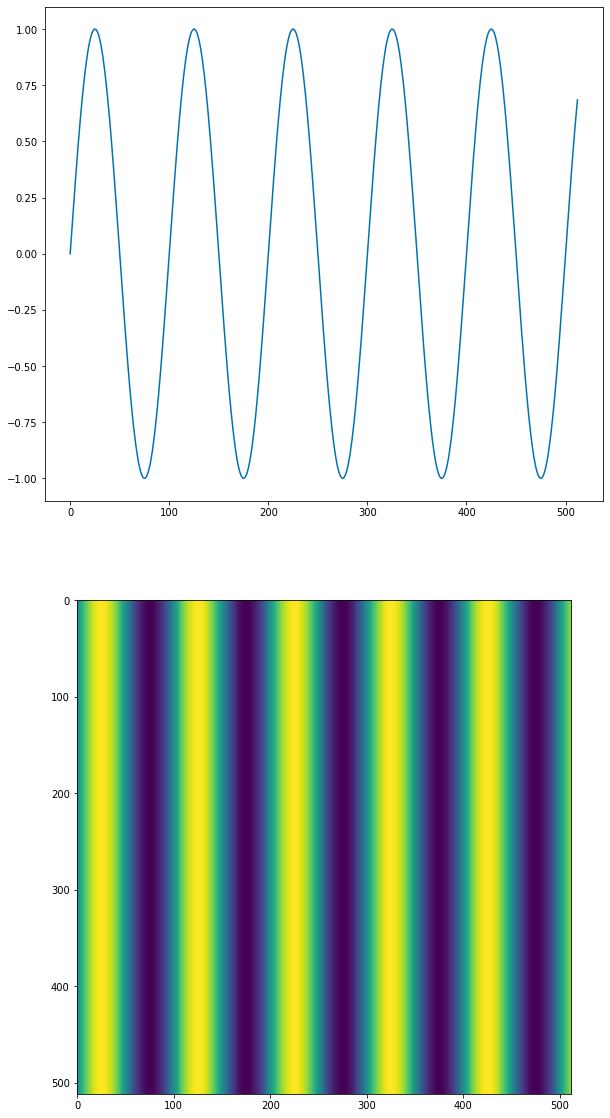

In [30]:
f = 1/100
image_size = 512
x = np.linspace(0, image_size, image_size)
wave = y = np.sin(x * f * (2 * np.pi))

image = np.ones(image_size)[:,np.newaxis] * wave[np.newaxis,:]

# Plot
fig, ax = plt.subplots(2, figsize=(10, 20))
ax[0].plot(x, wave)
ax[1].imshow(image);

And as with one-dimensional signals, sampling rate has a big effect on your ability to accurately capture the information carried by a signal:

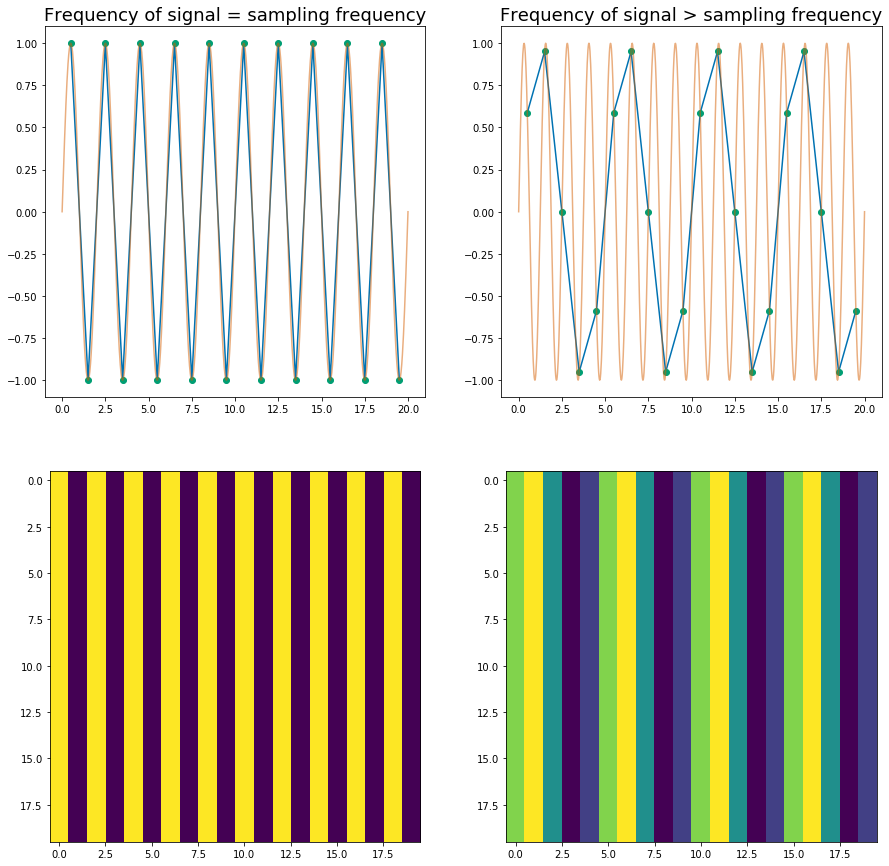

In [38]:
f = 1/2
image_size = 20
x = np.linspace(0, image_size-1, image_size) + .5
wave = np.sin(x * f * (2 * np.pi))
x_smooth = np.linspace(0, image_size, 1000)
y_smooth = np.sin(x_smooth * f * (2 * np.pi))
image = np.ones(image_size)[:,np.newaxis] * wave[np.newaxis,:]

f2 = 4/5
x2 = np.linspace(0, image_size-1, image_size) + .5
wave2 = np.sin(x2 * f2 * (2 * np.pi))
x_smooth2 = np.linspace(0, image_size, 1000)
y_smooth2 = np.sin(x_smooth2 * f2 * (2 * np.pi))
image2 = np.ones(image_size)[:,np.newaxis] * wave2[np.newaxis,:]

# Plot
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,15))

ax[0,0].plot(x, wave)
ax[0,0].plot(x, wave, 'o')
ax[0,0].plot(x_smooth, y_smooth, alpha=0.5)
ax[0,0].set_title('Frequency of signal = sampling frequency',
                 fontdict=font)
ax[1,0].imshow(image);

ax[0,1].plot(x2, wave2)
ax[0,1].plot(x2, wave2, 'o')
ax[0,1].plot(x_smooth2, y_smooth2, alpha=0.5)
ax[0,1].set_title('Frequency of signal > sampling frequency',
                 fontdict=font)
ax[1,1].imshow(image2);


Notice that, in the image on the right, the real signal frequency is higher than the image on the left, but the apparent signal is lower, because of aliasing.

We can create more complex wave images by combining 2D waves at perpendicular orientations:

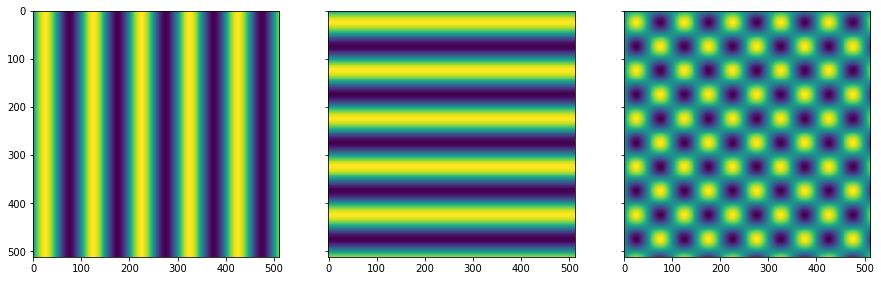

In [31]:
f = 1/100
image_size = 512
x = np.linspace(0, image_size, image_size)
wave = y = np.sin(x * f * (2 * np.pi))

image0 = np.ones(image_size)[:,np.newaxis] * wave[np.newaxis,:]
image1 = np.ones(image_size)[np.newaxis,:] * wave[:,np.newaxis]
image2 = wave[:, np.newaxis] * wave[np.newaxis,:]


# Plot
fig, ax = plt.subplots(ncols=3, figsize=(15, 12), sharey=True)
ax[0].imshow(image0)
ax[1].imshow(image1)
ax[2].imshow(image2);

Now lets consider the 2D aliasing example shown above, except now after combining perpendicular waves:

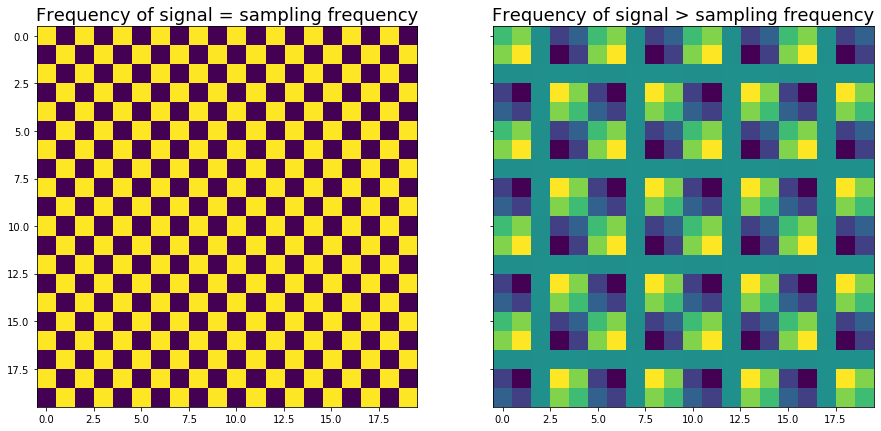

In [34]:
f = 1/2
image_size = 20
x = np.linspace(0, image_size-1, image_size) + .5
wave = np.sin(x * f * (2 * np.pi))
image = wave[:,np.newaxis] * wave[np.newaxis,:]

f2 = 4/5
x2 = np.linspace(0, image_size-1, image_size) + .5
wave2 = np.sin(x2 * f2 * (2 * np.pi))
image2 = wave2[:,np.newaxis] * wave2[np.newaxis,:]


# Plot
fig, ax = plt.subplots(ncols=2, figsize=(15, 12), sharey=True)
ax[0].imshow(image)
ax[0].set_title('Frequency of signal = sampling frequency',
               fontdict=font)
ax[1].imshow(image2)
ax[1].set_title('Frequency of signal > sampling frequency',
               fontdict=font);

In the above example, even though the frequencies used to create the image on the right are higher of that on the left, the periodicity of the image appears to be lower because of aliasing. Thus when you are looking at the image on the right, you might come to the wrong conclusion about the underlying signal.

To avoid aliasing artifacts, it is important to filter out information at frequencies higher than 0.5 the sampling rate **before you sample**. This is illustrated in the next example, which is interesting because it is real data. That's right, aliasing happens in real images too, even if there is no obvious periodicity as in our sine wave examples (actually, all images are just combinations of sine waves, but that is for the next lesson!).

In the example below, we start with a microscopy image (top), then resample at a lower sampling rate (middle). Next, we perform a Gaussian blur on the original high-resolution image, which removes high frequencies that would cause aliasing problems, and then we perform the downsampling (bottom).

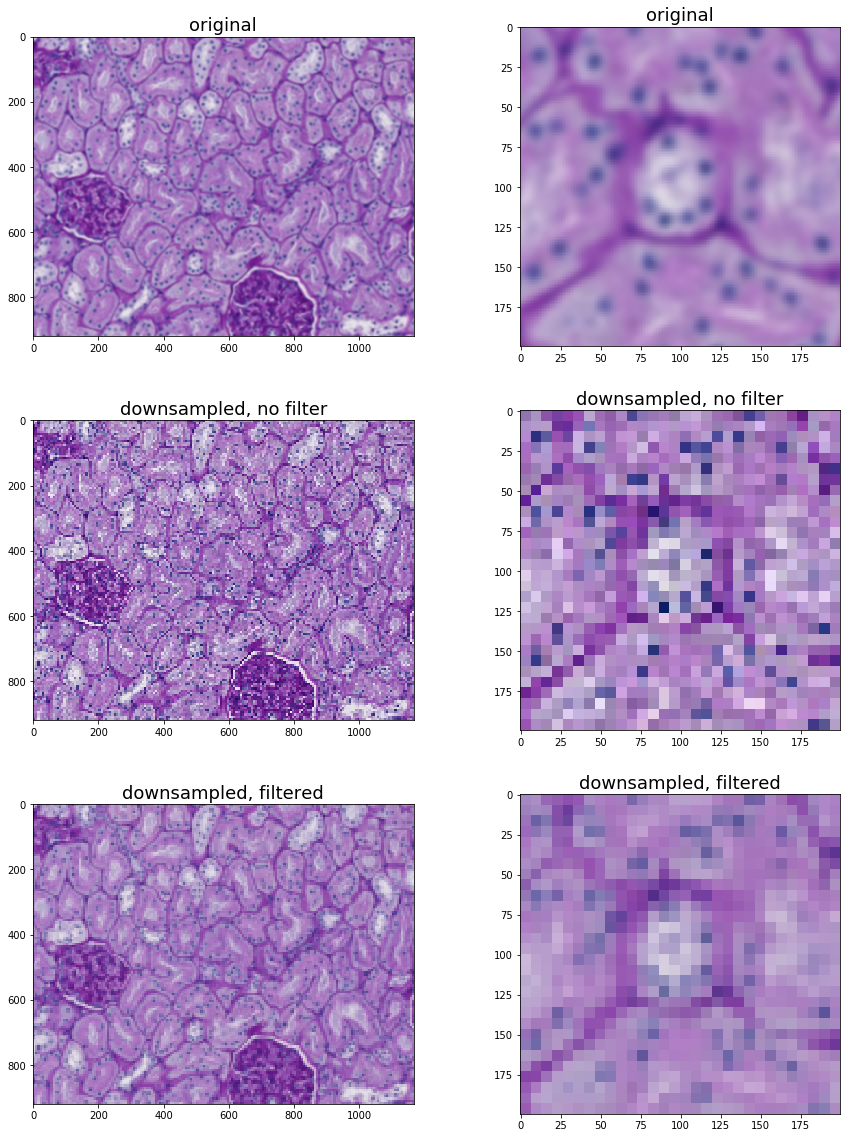

In [40]:
from skimage.transform import rescale
from skimage.filters import gaussian

downsample_factor = .15
upsample_factor = 1/downsample_factor

image = io.imread('../data/bear_kidney.png')
image2 = rescale(image, downsample_factor, order=0, anti_aliasing=False, multichannel=True)
image2 = rescale(image2, upsample_factor, order=0, multichannel=True)

sigma = (upsample_factor-1) / 2
image = gaussian(image, sigma, multichannel=True)
image3 = rescale(image, downsample_factor, order=0, anti_aliasing=False, multichannel=True)
image3 = rescale(image3, upsample_factor, order=0, multichannel=True)


# Plot
rmin = 600
rmax = 800
cmin = 400
cmax = 600

fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(15,20), sharey=False)
ax[0,0].imshow(image)
ax[0,0].set_title('original', fontdict=font)
ax[1,0].imshow(image2)
ax[1,0].set_title('downsampled, no filter', fontdict=font)
ax[2,0].imshow(image3)
ax[2,0].set_title('downsampled, filtered', fontdict=font)
ax[0,1].imshow(image[rmin:rmax, cmin:cmax])
ax[0,1].set_title('original', fontdict=font)
ax[1,1].imshow(image2[rmin:rmax, cmin:cmax])
ax[1,1].set_title('downsampled, no filter', fontdict=font)
ax[2,1].imshow(image3[rmin:rmax, cmin:cmax])
ax[2,1].set_title('downsampled, filtered', fontdict=font);

Notice that the unfiltered, downsampled image appears more pixelated and discontinuous. You can actually see what appear to be breaks in the dark purple intercellular regions, even though the are no breaks in the original high resolution image. Some of the dark blue pixel clusters that represent the nuclei also might look a bit strange compared to what you expect.

Looking at the filtered, downsampled image, you can see that the dark purple regions don't look as broken up, and the dark blue pixels look more representative of the nuclei in the original image. Although this image is very low resolution, it looks smoother and more "biological" compared to the unfiltered image.

At this point, you might be a bit confused as to how a Gaussian blur can remove high frequencies from a natural image. Actually, you might be curious how you can describe a natural image as containing frequencies at all! This will all be cleared up in the next lesson.

## Challenges

1. Create a 1D signal (1000 samples) from -10 to 10 seconds that is the combination of three sine waves (f = 1/9, 1/2, and 1) and plot the result.
2. Plot the same signal with a sample rate equal to 1.
    - Hint: `sample_rate = (n_samples - 1) / n_seconds`
3. Now rerun the code for **Challenge 2** (copy and paste into a new cell), but combine only the two lower frequency sine waves for your starting signal. How do the plots for **2** and **3** compare?
4. What happens if you perform a Gaussian blur on the image above *after* downsampling? Try a range of sigma values. How does this compare to the image in which you filtered prior to downsampling?

## Solutions

### Challenge 1 Solution

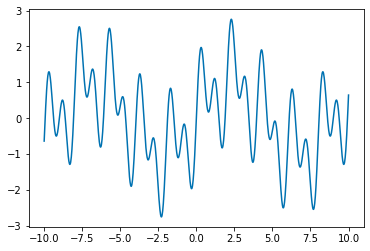

In [19]:
f = [1/9, 1/2, 1]
n_samples = 1000
x = np.linspace(-10, 10, n_samples)
y = [np.sin(x * freq * (2 * np.pi)) for freq in f] 
y = np.sum(y, axis=0)

plt.plot(x,y);

### Challenge 2 Solution

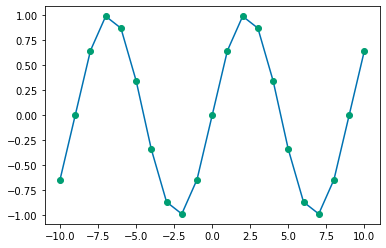

In [20]:
f = [1/9, 1/2, 1]
sample_rate = 1
n_samples = sample_rate * 20 + 1
x = np.linspace(-10, 10, n_samples)
y = [np.sin(x * freq * (2 * np.pi)) for freq in f] 
y = np.sum(y, axis=0)

plt.plot(x,y)
plt.plot(x,y, 'o');

### Challenge 3 Solution

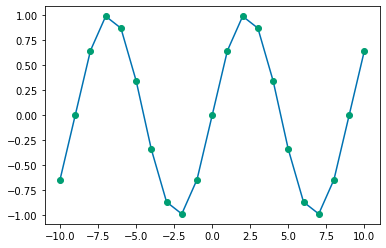

In [21]:
# Note that this produces the same output as the Challenge 2 solution,
# despite not including the highest frequency component

f = [1/9, 1/2]
sample_rate = 1
n_samples = sample_rate * 20 + 1
x = np.linspace(-10, 10, n_samples)
y = [np.sin(x * freq * (2 * np.pi)) for freq in f] 
y = np.sum(y, axis=0)

plt.plot(x,y)
plt.plot(x,y, 'o');

### Challenge 4 Solution

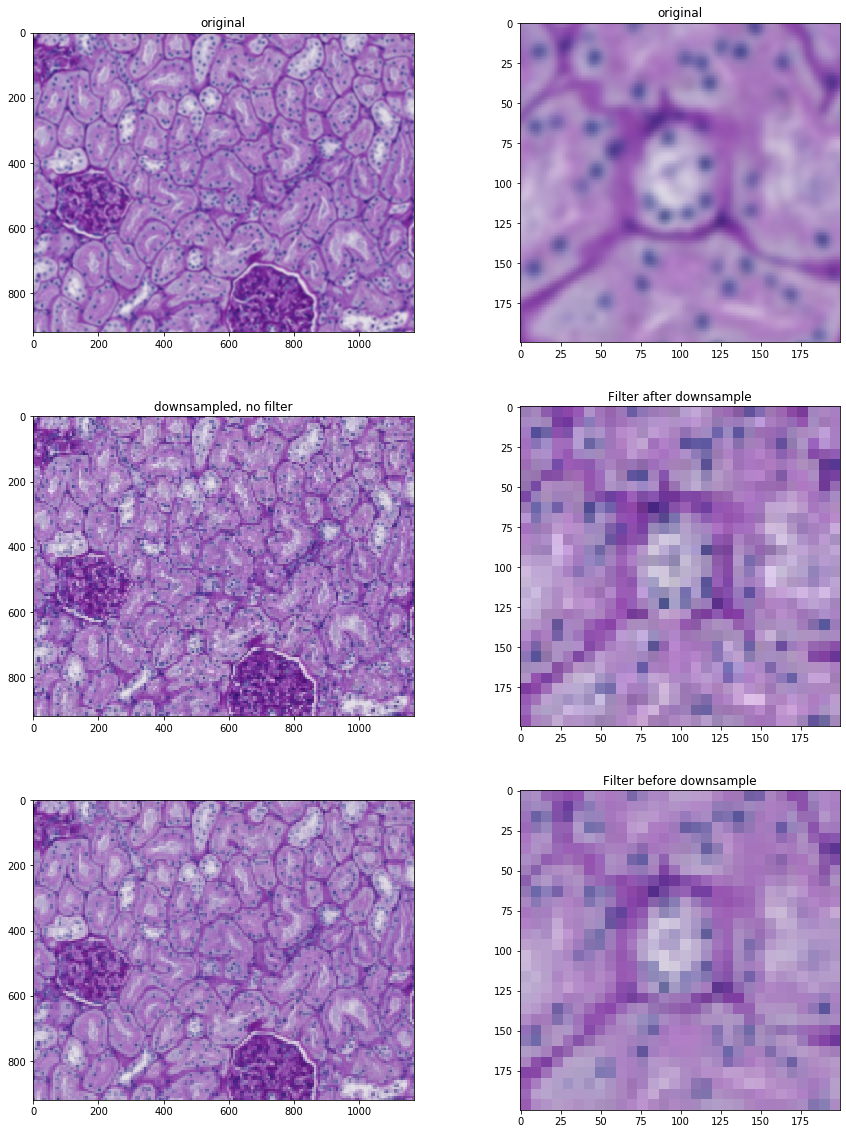

In [22]:
downsample_factor = .15
upsample_factor = 1/downsample_factor

manual_sigma = 0.5 # Change this to see the effect of sigma on filtering after downsampling

image = io.imread('../data/bear_kidney.png')
image2 = rescale(image, downsample_factor, order=0, anti_aliasing=False, multichannel=True)
image2 = gaussian(image2, manual_sigma, multichannel=True)
image2= rescale(image2, upsample_factor, order=0, multichannel=True)

sigma = (upsample_factor - 1) / 2
image = gaussian(image, sigma, multichannel=True)
image3 = rescale(image, downsample_factor, order=0, anti_aliasing=False, multichannel=True)
image3 = rescale(image3, upsample_factor, order=0, multichannel=True)

rmin = 600
rmax = 800
cmin = 400
cmax = 600

fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(15,20), sharey=False)
ax[0,0].imshow(image)
ax[0,0].set_title('original')
ax[1,0].imshow(image2)
ax[1,0].set_title('downsampled, no filter')
ax[2,0].imshow(image3)
ax[0,1].imshow(image[rmin:rmax, cmin:cmax])
ax[0,1].set_title('original')
ax[1,1].imshow(image2[rmin:rmax, cmin:cmax])
ax[1,1].set_title('Filter after downsample')
ax[2,1].imshow(image3[rmin:rmax, cmin:cmax])
ax[2,1].set_title('Filter before downsample');